<div align="center" style='font-size: 21px; margin: 21px'><u><b>Классификация удовлетворённости пассажира</b><u></div>
 <div align="right" style='width: 333px; margin-left: auto; margin-bottom: 21px'><u><b>* Построение модели для классификации удовлетворённости пассажира </b><u></div>
        

<!-- <a id="ref3"></a> 
 -->
<div style="background-color: #BDDBF9; margin-top: 8px; padding: 22px; box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px;">
    <p style='font-size: 21px'>Содержание</p>
    <ol>
        <li><a style='' href="#ref1">Описание данных</a></li>
        <li><a style='' href="#ref2">Импорт данных и подготовка</a></li>
        <li><a style='' href="#ref3">Изучение данных</a></li>
        <li><a style='' href="#ref4">Очистка данных</a></li>
        <li><a style='' href="#ref5">Визуализация данных</a></li>
        <li><a style='' href="#ref7">Создание модели</a></li> 
        <li><a style='' href="#ref8">Заключение</a></li>
    </ol>
</div>

<a id="ref1"></a> 

Имеются данные об удовлетворенности клиентов авиакомпании. Я построю модель прогнозирования удовлетворенности клиентов авиакомпании, предварительно обработаю данные и проведу оценку эффективности моделей. 

<!-- <b>Удовлетворенность</b> — это субъективная оценка потребителем степени удовлетворения желаний и требований, возникающих при приобретении или потреблении предоставленного продукта или услуги, а возможность повторного использования — это возможность того, что покупатель будет продолжать использовать продукт или услугу повторно после покупки. Чтобы доказать корреляцию между удовлетворенностью клиентов и намерением повторного использования, была продемонстрирована высокая корреляция между переменными путем проведения анализа корреляции между удовлетворенностью клиентов и намерением повторного использования для предприятий быстрого питания, предприятий по борьбе с вредителями, банков и прачечных за границей. Данные этого исследования представляют собой данные об удовлетворенности клиентов авиакомпаний, в том числе пол, возраст, питание и напитки на борту, удобство сидений и т. д. Они собираются Google Kaggle. Внедрение модели прогнозирования удовлетворенности клиентов авиакомпании и оценка эффективности выполняются с предварительной обработкой.

</p><b>Satisfaction</b> is a consumer's subjective evaluation of the extent to which desires and demands arising from
acquiring or consuming a provided product orservice are satisfied, and reusability isthe possibility that the customer
will continue to use the product or service repeatedly after purchasing. To prove the correlation between
customer satisfaction and reuse intention, a high correlation between variables is demonstrated by conducting a
correlation analysis between customer satisfaction and reuse intention for fast food businesses, pest control
businesses, banks, and laundry businesses overseas. 
<p>
    The data on this study are <b>Airline customer satisfaction data</b>, which are including gender, age, food and beverages
provided on board, seat comfort, etc. They are collected by <b>Google's Kaggle</b>.

Airline customer satisfaction prediction model implementation, and performance evaluation are conducted with pre-processing. -->

<a id="ref2"></a> 
### Импорт библиотек, создание функций

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score#plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline
import time
from gitly.colab.plot import GitlyPlotter
gitly = GitlyPlotter('github')
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from sklearn import metrics

/var/folders/9_/ll5ms3kn1cvgh7ng385rxvq40000gn/T/ipykernel_13837/4224254715.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


This script was made to run only on Google Colab notebooks, other environments was not tested completely
You are not in Colab envirement, make sure you already have Plotly > 4.9.0 and kaleido


In [2]:
def cf_matrix_plot(y_test, X_test, model):
    """Матрица путаницы"""
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='RdYlBu')

    ax.set_title('Матрица путаницы\n\n');
    ax.set_xlabel('\nПредсказания')
    ax.set_ylabel('Фактические значения');
    ax.xaxis.set_ticklabels(['Ложь','Истина'])
    ax.yaxis.set_ticklabels(['Ложь','Истина'])
    return plt.show()

In [3]:
def roc_auc(model,  roc_auc, X_test, y_test):
    """Нахождение площади под кривой ошибок, построение графика"""
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    fig = px.area(
        x=fpr, y=tpr,
        labels=dict(x='Ложноположительная доля', y='Истинно положительная доля'),
        width=700, height=500
    )
    fig.update_layout(
    title=f'{model} - площадь под ROC-кривой={roc_auc:.4f})',
    title_x=0.5   
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show('svg')

In [4]:
def model_create(model, X_train, y_train, X_test, y_test):
    """Обучение модели, оценка точности модель"""
    intial_time=time.time()
    model.fit(X_train,y_train.ravel())
        
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Точность прогноза = {}".format(accuracy))
    roc_auc = metrics. roc_auc_score (y_test, y_pred)
    print("AUC ROC - Площадь под кривой ошибок = {}".format(roc_auc))
    
    time_taken = time.time()-intial_time
    print("Затраченное время = {}".format(time_taken))
    
    print(classification_report(y_test,y_pred,digits=5))
    cf_matrix_plot(y_test, X_test, model) 
    return model, accuracy, roc_auc, time_taken

In [5]:
def age(agevalue):
    """Категория возраста"""
    if agevalue < 40:
        return 1
    elif agevalue < 60:
        return 2
    else:
        return 3

In [6]:
def show_missing(df):
    """Возвращает df - тип, количество, кол.уникальных, NaN и % NaN"""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'Колонка': variables, 
        'Тип значений': dtypes,
        'Количество значений': count,
        'Кол.уникальные значения': unique,
        'Кол.NaN': missing, 
        '% NaN': pc_missing
    })    
        
    return output

<br>

### Чтение и подготовка данных 

In [7]:
df = pd.read_csv("../f/Airline_Passenger_Satisfaction.csv", usecols=range(1,25))

In [8]:
pd.set_option('display.max_columns', None)
df.sample(4)

,ID,Пол,Возраст,Тип клиента,Тип путешествия,Класс,Дальность полёта,Задержка вылета,Задержка прибытия,Удобство времени вылета и прибытия,Простота онлайн бронирования,Услуга регистрации заезда,Онлайн-посадка,Расположение ворот,Обслуживание на борту,Комфорт сидения,Обслуживание в номерах для ног,Чистоплотность,Еда и напитки,Обслуживание понимаете,Услуга wi-fi в полёте,Развлечения на борту,Обработка багажа,Удовлетворённость
17812,17813,Мужчина,47,Возвращаемый,Бизнес,Бизнес класс,2738,0,0.0,2,4,5,3,2,2,1,2,1,2,2,2,2,2,Неудовлетворённый
49702,49703,Мужчина,57,Возвращаемый,Бизнес,Бизнес класс,2136,0,0.0,3,3,2,3,3,3,5,4,1,2,3,3,3,4,Неудовлетворённый
26159,26160,Женщина,22,Первый раз,Бизнес,Эконом класс,404,0,0.0,0,0,4,0,3,5,4,5,4,4,5,1,4,1,Удовлетворённый
37166,37167,Мужчина,55,Возвращаемый,Личный,Эконом класс,1129,11,7.0,4,4,5,4,5,4,3,2,3,3,5,4,3,5,Удовлетворённый


###  Преобразуем именно столбцов в формат camelCase

In [9]:
def rename_col(df=df):
    df = df.rename(columns = {'Пол': 'gender',
                              'Возраст': 'age', 
                              'Тип клиента': 'customerType', 
                              'Тип путешествия': 'typeOfTravel', 
                              'Класс': 'class',
                              'Дальность полёта': 'flightDistance', 
                              'Задержка вылета': 'departureDelay', 
                              'Задержка прибытия': 'arrivalDelay',
                              'Удобство времени вылета и прибытия': 'departureAndArrivalTimeConvenience', 
                              'Простота онлайн бронирования': 'easeOfOnlineBooking',
                              'Услуга регистрации заезда': 'checkInService', 
                              'Онлайн-посадка': 'onlineBoarding', 
                              'Расположение ворот': 'gateLocation',
                              'Обслуживание на борту': 'onBoardService', 
                              'Комфорт сидения': 'seatComfort', 
                              'Обслуживание в номерах для ног': 'legRoomService', 
                              'Чистоплотность': 'cleanliness',
                              'Еда и напитки': 'foodAndDrink', 
                              'Обслуживание понимаете': 'inflightService', 
                              'Услуга wi-fi в полёте': 'inFlightWifiService',
                              'Развлечения на борту': 'inflightEntertainment',
                              'Обработка багажа': 'baggageHandling', 
                              'Удовлетворённость': 'satisfaction'})
    return df

In [10]:
df = df.rename(columns = {'Пол': 'gender',
                              'Возраст': 'age', 
                              'Тип клиента': 'customerType', 
                              'Тип путешествия': 'typeOfTravel', 
                              'Класс': 'class',
                              'Дальность полёта': 'flightDistance', 
                              'Задержка вылета': 'departureDelay', 
                              'Задержка прибытия': 'arrivalDelay',
                              'Удобство времени вылета и прибытия': 'departureAndArrivalTimeConvenience', 
                              'Простота онлайн бронирования': 'easeOfOnlineBooking',
                              'Услуга регистрации заезда': 'checkInService', 
                              'Онлайн-посадка': 'onlineBoarding', 
                              'Расположение ворот': 'gateLocation',
                              'Обслуживание на борту': 'onBoardService', 
                              'Комфорт сидения': 'seatComfort', 
                              'Обслуживание в номерах для ног': 'legRoomService', 
                              'Чистоплотность': 'cleanliness',
                              'Еда и напитки': 'foodAndDrink', 
                              'Обслуживание понимаете': 'inflightService', 
                              'Услуга wi-fi в полёте': 'inFlightWifiService',
                              'Развлечения на борту': 'inflightEntertainment',
                              'Обработка багажа': 'baggageHandling', 
                              'Удовлетворённость': 'satisfaction'})

In [11]:
# rename_col()
display(df.sample(2))

,ID,gender,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
124866,124867,Женщина,53,Возвращаемый,Личный,Эконом плюс,280,0,0.0,4,4,3,4,4,2,4,4,4,3,2,4,2,2,Удовлетворённый
15871,15872,Женщина,46,Возвращаемый,Бизнес,Бизнес класс,1909,24,11.0,2,2,2,4,2,4,4,3,4,2,4,4,4,4,Удовлетворённый


<br><a id="ref3"></a> 
### Изучение данных 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ID                                  129880 non-null  int64  
 1   gender                              129880 non-null  object 
 2   age                                 129880 non-null  int64  
 3   customerType                        129880 non-null  object 
 4   typeOfTravel                        129880 non-null  object 
 5   class                               129880 non-null  object 
 6   flightDistance                      129880 non-null  int64  
 7   departureDelay                      129880 non-null  int64  
 8   arrivalDelay                        129487 non-null  float64
 9   departureAndArrivalTimeConvenience  129880 non-null  int64  
 10  easeOfOnlineBooking                 129880 non-null  int64  
 11  checkInService            

In [13]:
df.dtypes

ID                                      int64
gender                                 object
age                                     int64
customerType                           object
typeOfTravel                           object
class                                  object
flightDistance                          int64
departureDelay                          int64
arrivalDelay                          float64
departureAndArrivalTimeConvenience      int64
easeOfOnlineBooking                     int64
checkInService                          int64
onlineBoarding                          int64
gateLocation                            int64
onBoardService                          int64
seatComfort                             int64
legRoomService                          int64
cleanliness                             int64
foodAndDrink                            int64
inflightService                         int64
inFlightWifiService                     int64
inflightEntertainment             

In [14]:
# Получим колонки, с которыми будем работать 
df.columns

Index(['ID', 'gender', 'age', 'customerType', 'typeOfTravel', 'class',
       'flightDistance', 'departureDelay', 'arrivalDelay',
       'departureAndArrivalTimeConvenience', 'easeOfOnlineBooking',
       'checkInService', 'onlineBoarding', 'gateLocation', 'onBoardService',
       'seatComfort', 'legRoomService', 'cleanliness', 'foodAndDrink',
       'inflightService', 'inFlightWifiService', 'inflightEntertainment',
       'baggageHandling', 'satisfaction'],
      dtype='object')

> краткий обзор, что содержит данные 

In [15]:
# Создаем df-обзор колонок
df_about = show_missing(df)

In [16]:
# Переворачиваем таблицу
df_about = df_about.transpose().rename(columns=df_about.transpose().iloc[0]).iloc[1:,:]

In [17]:
df_about

,ID,gender,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
Тип значений,int64,object,int64,object,object,object,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object
Количество значений,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880
Кол.уникальные значения,129880,2,75,2,2,3,3821,466,473,6,6,6,6,6,6,6,6,6,6,6,6,6,5,2
Кол.NaN,0,0,0,0,0,0,0,0,393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
% NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Уникальные значения каждого столбца
df_about.iloc[[2]]

,ID,gender,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
Кол.уникальные значения,129880,2,75,2,2,3,3821,466,473,6,6,6,6,6,6,6,6,6,6,6,6,6,5,2


In [19]:
print("Количество пассажиров:      ", df.shape[0])
print("Количество атрибутов таблици: ",df.shape[1])

Количество пассажиров:       129880
Количество атрибутов таблици:  24


<a id="ref4"></a> 
<br>
## Очистка данных 
Избавимся от 
* Дубликатов
* Нулевых значений

#### Заполнение пропусков столбца "Задержка прибытия" средним значением 

In [20]:
df.arrivalDelay = df.arrivalDelay.fillna(df.arrivalDelay.mean())

In [21]:
print('Количество нулевых значений :',df.isna().sum().sum())

Количество нулевых значений : 0


In [22]:
print('Количество дубликатов :',df.duplicated().sum())

Количество дубликатов : 0


##### Теперь наши данные готовы к изучению, визуализации и, наконец, к прогнозированию.

### Получим уникальные значения определённых столбцов 

In [23]:
list_unique = ['gender', 'customerType', 'class', 'satisfaction', 'typeOfTravel']
dict_unique = {}

In [24]:
print('УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦОВ:')
for (index, i) in enumerate(list_unique): 
    print(i, ' - ',  df[f'{i}'].unique())

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦОВ:
gender  -  ['Мужчина' 'Женщина']
customerType  -  ['Первый раз' 'Возвращаемый']
class  -  ['Бизнес класс' 'Эконом класс' 'Эконом плюс']
satisfaction  -  ['Удовлетворённый' 'Неудовлетворённый']
typeOfTravel  -  ['Бизнес' 'Личный']


<br><a id="ref5"></a> 
### Визуализация данных

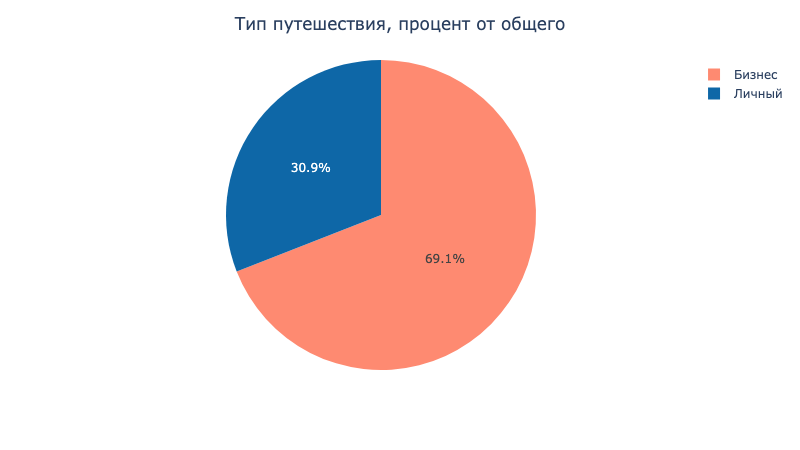

In [25]:
fig = px.pie(df, names = df['typeOfTravel'].value_counts().keys(),
                 values = df['typeOfTravel'].value_counts().values, width=100, height=100,
                 color_discrete_sequence=['#FE8A71', '#0E67A7', '#3DA4AB'])
fig.update_layout(
title='Тип путешествия, процент от общего',
title_x=0.5)
gitly.show(fig)

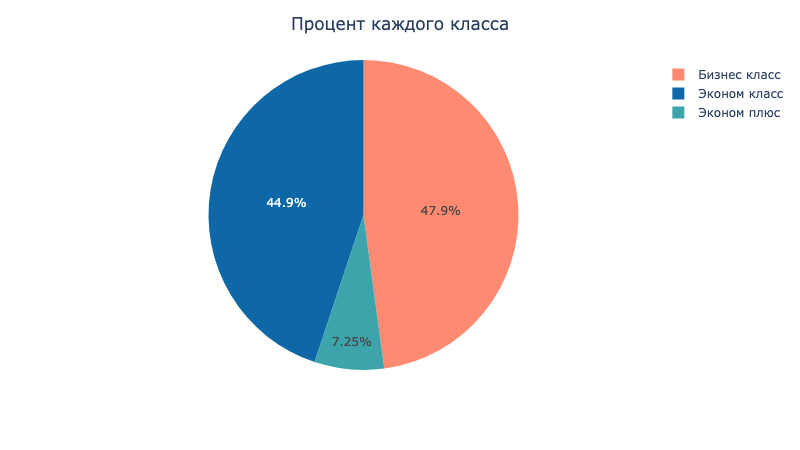

In [26]:
fig = px.pie(df, names = df['class'].value_counts().keys(),
                 values = df['class'].value_counts().values, width=100, height=100,
                 color_discrete_sequence=['#FE8A71', '#0E67A7', '#3DA4AB'])
fig.update_layout(
title='Процент каждого класса',
title_x=0.5)
gitly.show( fig )

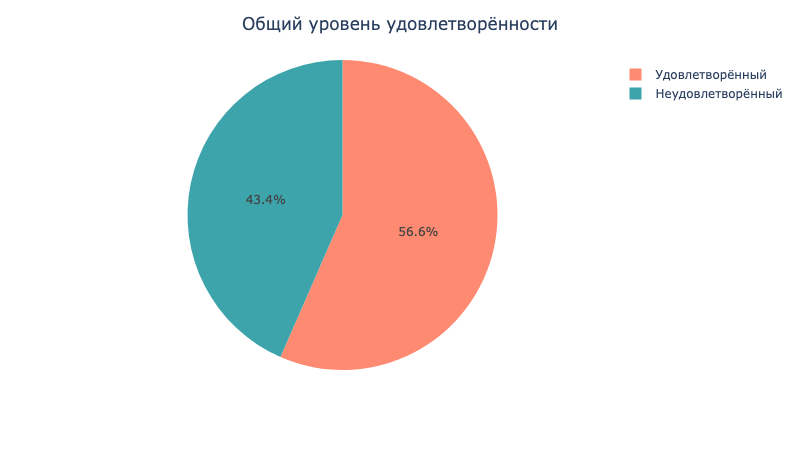

In [27]:
fig = px.pie(df, names = df['satisfaction'].value_counts().keys(),
                 values = df['satisfaction'].value_counts().values, width=100, height=100,
                 color_discrete_sequence=['#FE8A71', '#3DA4AB', '#0E67A7'])
fig.update_layout(
title='Общий уровень удовлетворённости',
title_x=0.5)
gitly.show( fig )

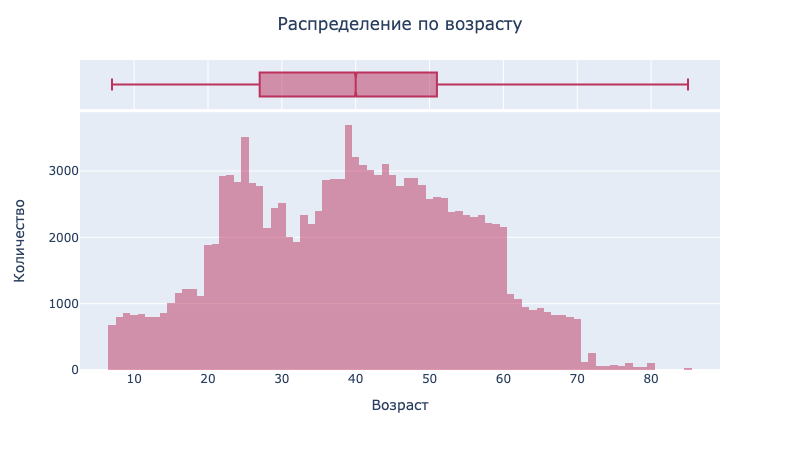

In [28]:
fig = px.histogram(df, x = 'age',  marginal ='box', barmode = 'overlay',
                 color_discrete_sequence=['#BC325C'])
fig.update_layout(
    title='Распределение по возрасту',
    xaxis_title="Возраст",
    yaxis_title="Количество",
    title_x=0.5
)
gitly.show( fig )

* Уровень удовлетворенности более 50%.
* По данным пассажиров, в классе путешествий преобладают бизнес-класс (48%) и эконом класс (45%), а остальные — эконом-плюс (7%).
* Возрастные выбросы не так значительны

In [29]:
list_plot = ['gender', 'customerType', 'class']

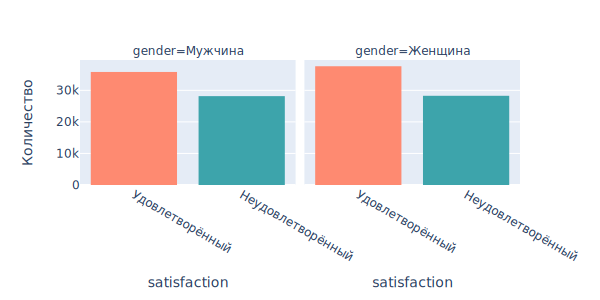

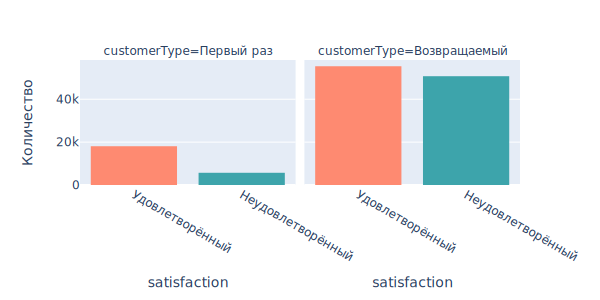

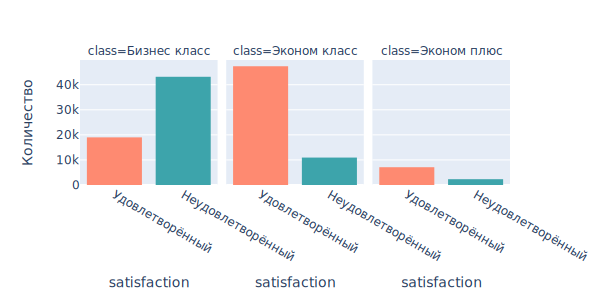

In [30]:
pio.renderers.default = "notebook_connected"
for (index, elem) in enumerate(list_plot): 
    fig = px.histogram(data_frame = df
                       ,facet_col = f'{elem}'
                       ,x = 'satisfaction',
                       width=600, height=300
                    , color = 'satisfaction',
                 color_discrete_sequence=['#FE8A71', '#3DA4AB', '#0E67A7']
             )
    fig.update_layout(showlegend=False)
    fig.update_layout(
    yaxis_title="Количество",
    title_x=0.5
    )
    fig.show("svg")

* Gender : Males and Females are almost the same with the satisfaction and dissatisfaction level so satisfaction behaviour is almost the same.
* Customer Type: Those who are returning are having almost the same level of people who are satisfied or Neutral or Dissatisfied and customers with first time are with most dissatisfied.
* Class : satisfaction level is more only for business class    

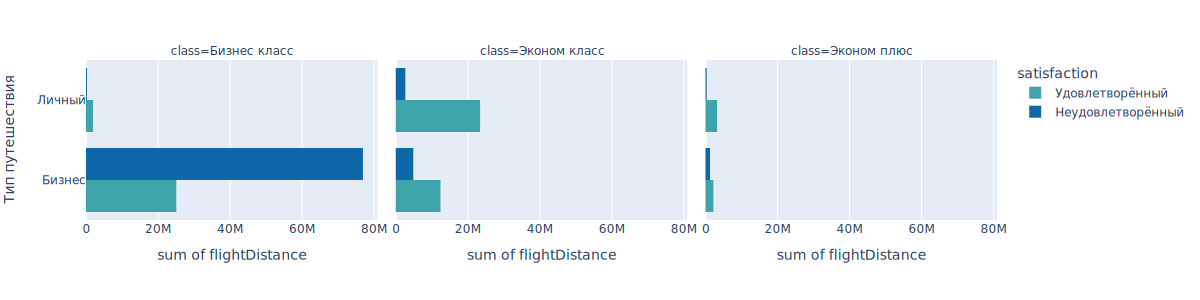

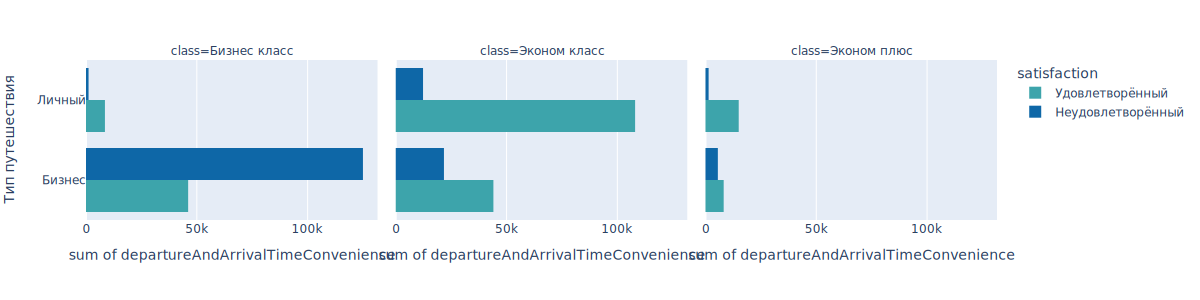

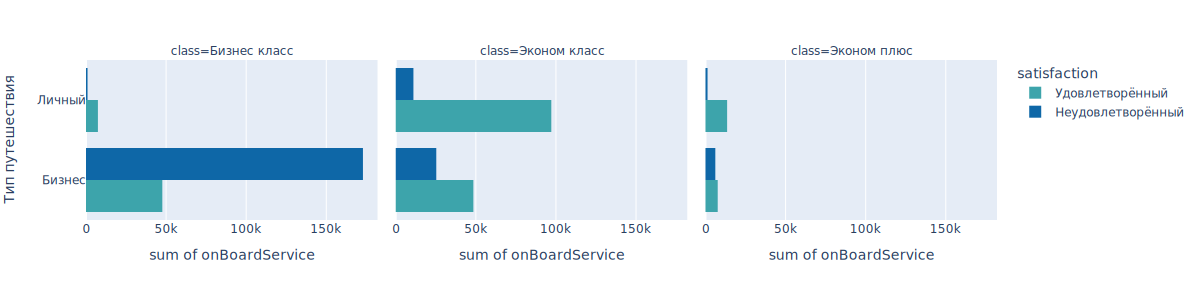

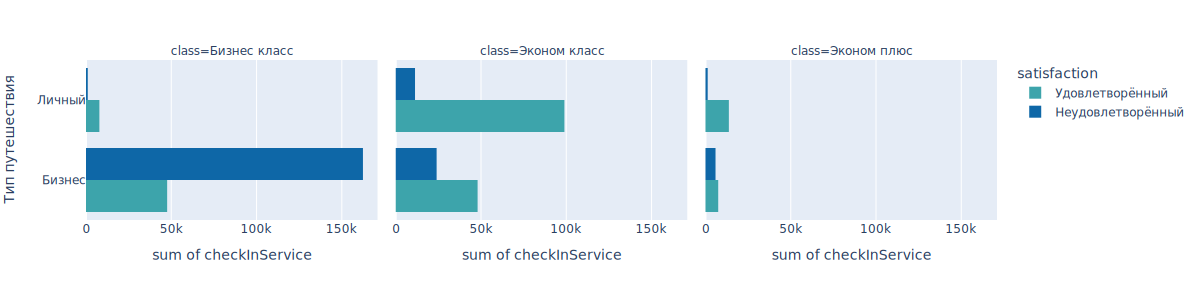

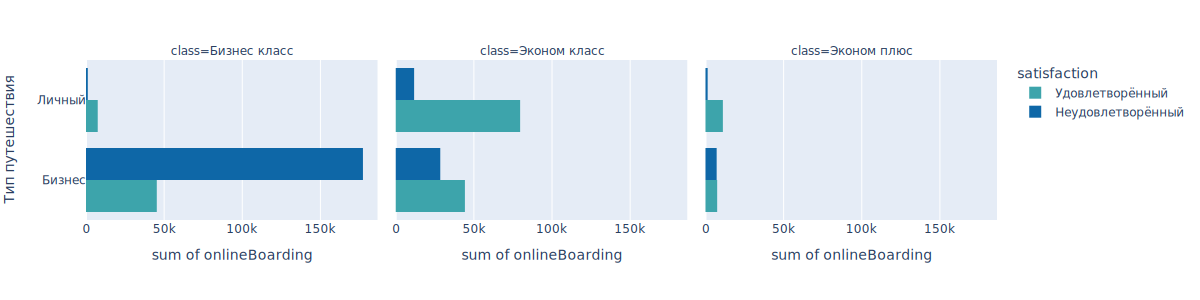

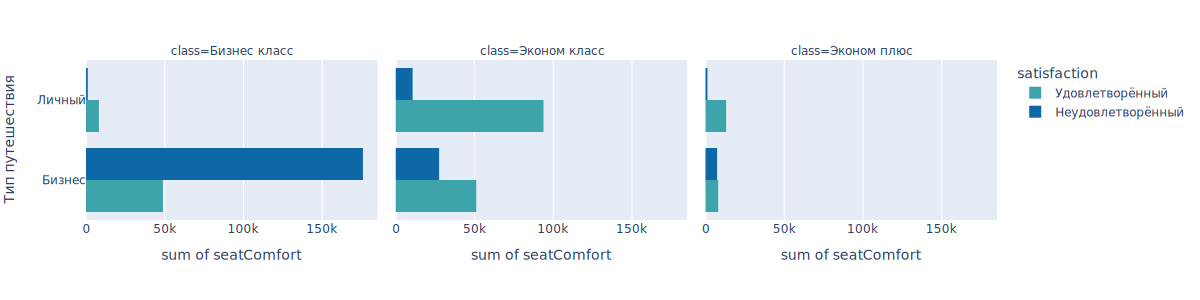

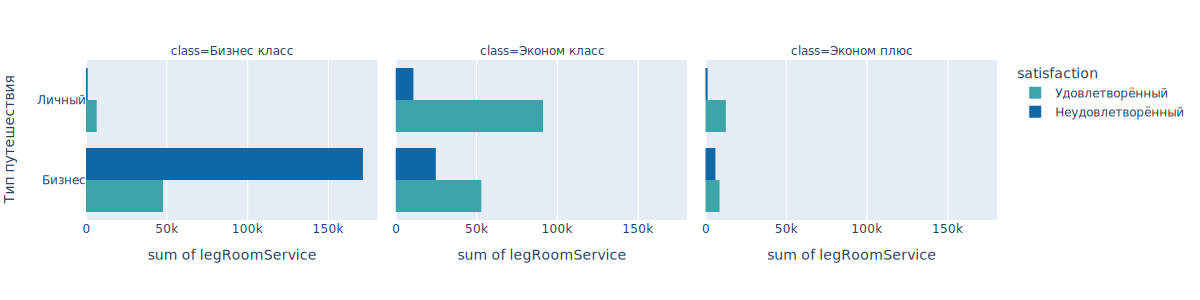

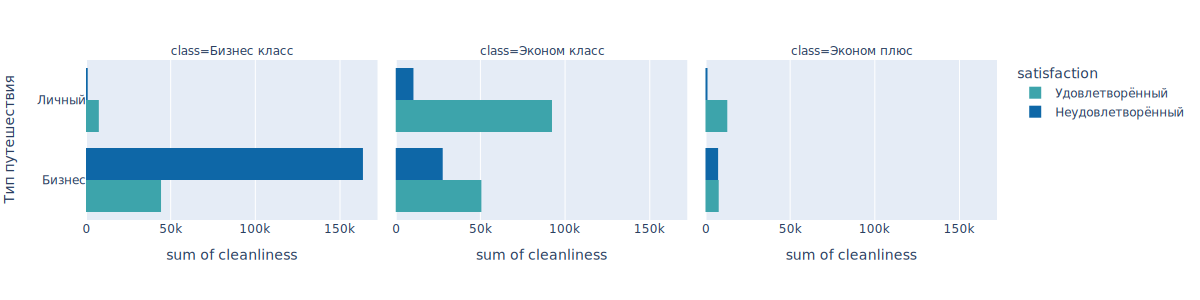

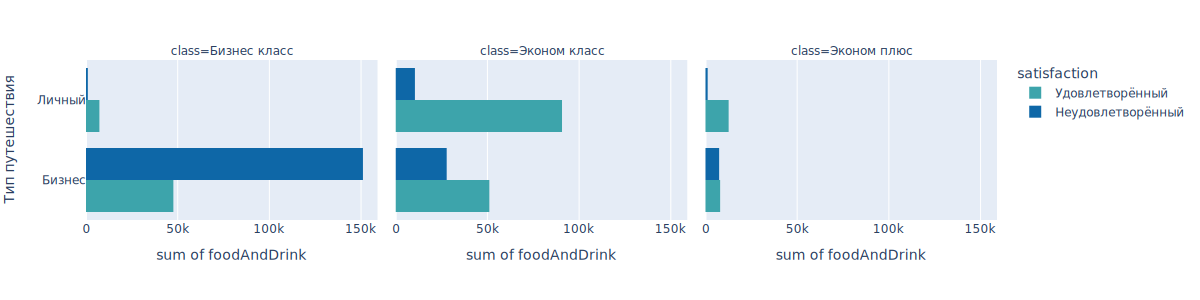

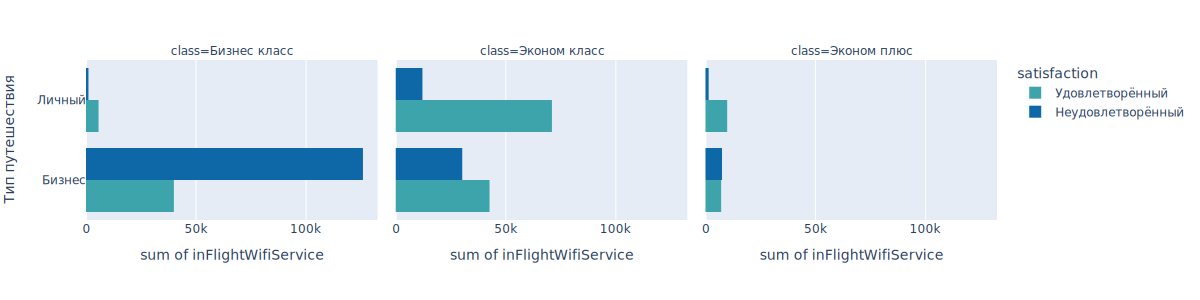

In [31]:
list_plot2 = ['flightDistance', 'departureAndArrivalTimeConvenience', 'onBoardService', 'checkInService', \
              'onlineBoarding', 'seatComfort', 'legRoomService', 'cleanliness', 'foodAndDrink', \
              'inFlightWifiService']

for (index, elem) in enumerate(list_plot2): 
    fig = px.histogram(data_frame = df
                       ,y = 'typeOfTravel', x = f'{elem}'
                       ,facet_col = 'class', barmode="group",
                       width=1200, height=300
                    , color = 'satisfaction',
                 color_discrete_sequence=['#3DA4AB', '#0E67A7', '#FE8A71']
             )
    fig.update_layout(
        yaxis_title="Тип путешествия",
        title_x=0.5
    )
    fig.show("svg")

In [32]:
display(pd.pivot_table(data=df, values='age', index='gender', columns='class', aggfunc='count'))

class,Бизнес класс,Эконом класс,Эконом плюс
gender,,,
Женщина,31263,29670,4966
Мужчина,30897,28639,4445


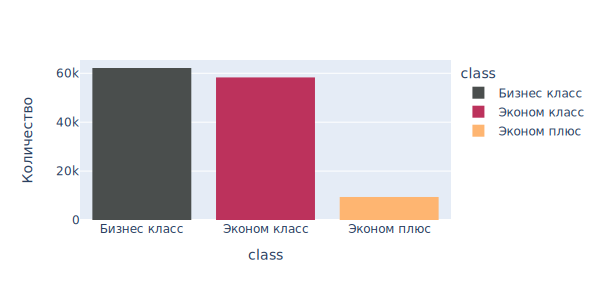

In [33]:
fig = px.histogram(df, x="class", color="class", width=600, height=300,
                   nbins=34, color_discrete_sequence=['#4A4E4D', '#BC325C', '#FEB571'])
fig.update_layout(
    yaxis_title="Количество",
    title_x=0.5
)
fig.show("svg")

<u>Данные были исследованы, далее приступаем для обучения и создания модели для прогноза.<u>

#### Столбец с полом и номером ID клиента не имеют отношения к удовлетворенности, откажемся от этих столбцов для создания идеальной модели. 

In [34]:
df.satisfaction = df.satisfaction.replace({"Неудовлетворённый": 0, "Удовлетворённый": 1})
df['class'] = df['class'].replace({"Бизнес класс":2, "Эконом класс": 1, 'Эконом плюс': 0})
df.customerType = df.customerType.replace({'Первый раз': 0, 'Возвращаемый': 1}) 
df.typeOfTravel = df.typeOfTravel.replace({"Бизнес":0, "Личный": 1})

In [35]:
# Применяем функцию 
df.age = df.age.apply(age)

- категориальные данные преобразованы, избавимся от ненужных столбцов 

In [36]:
df.drop(['gender',"ID"],axis=1, inplace=True)

In [37]:
df.sample(4)

,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
93870,1,0,0,2,590,0,10.0,5,5,5,5,1,5,2,3,2,2,5,5,2,4,0
31966,2,1,0,2,2810,0,0.0,5,4,3,4,5,4,5,4,5,3,4,5,4,5,0
105077,1,1,0,2,2360,13,0.0,1,1,5,4,1,4,5,4,3,3,4,1,4,4,0
124373,3,1,0,1,575,2,3.0,1,1,3,3,1,2,4,2,4,3,2,2,2,2,1


#### Получим статистику и корреляцию данных 

In [38]:
df.describe()

,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,1.600801,0.816908,0.309416,1.406136,1190.316392,14.713713,15.091129,3.057599,2.756876,3.306267,3.252633,2.976925,3.383023,3.441361,3.350878,3.286326,3.204774,3.642193,2.728696,3.358077,3.632114,0.565537
std,0.654171,0.386743,0.462255,0.621378,997.452477,38.071126,38.407410,1.526741,1.401740,1.266185,1.350719,1.278520,1.287099,1.319289,1.316252,1.313682,1.329933,1.176669,1.329340,1.334049,1.180025,0.495688
min,1.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,414.000000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,1.000000
max,3.000000,1.000000,1.000000,2.000000,4983.000000,1592.000000,1584.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [39]:
cor = df.corr(method = 'pearson')
cor = round(abs(cor.satisfaction), 2)
cor.sort_values(ascending=False)

satisfaction                          1.00
onlineBoarding                        0.50
typeOfTravel                          0.45
class                                 0.45
inflightEntertainment                 0.40
seatComfort                           0.35
onBoardService                        0.32
legRoomService                        0.31
cleanliness                           0.31
flightDistance                        0.30
inFlightWifiService                   0.28
baggageHandling                       0.25
inflightService                       0.24
checkInService                        0.24
foodAndDrink                          0.21
customerType                          0.19
easeOfOnlineBooking                   0.17
age                                   0.09
arrivalDelay                          0.06
departureAndArrivalTimeConvenience    0.05
departureDelay                        0.05
gateLocation                          0.00
Name: satisfaction, dtype: float64

#### Как мы видим, расположение ворот не имеет корреляции с удовлетворением пассажира

<a id="ref7"></a> 
### Создание модели прогноза

#### <u>Разделим набор данных<u>


In [40]:
X = df.drop(['satisfaction', "gateLocation"], axis=1)
y = df['satisfaction']

In [41]:
X.sample(3)

,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling
75106,1,1,1,2,1723,0,28.0,4,1,3,1,4,2,2,2,2,5,1,2,4
41282,2,1,1,1,788,7,2.0,4,2,4,2,5,2,3,2,2,4,2,2,4
29929,1,1,0,2,571,0,0.0,2,5,5,5,1,5,3,5,5,1,2,5,4


In [42]:
y.sample(3)

51786    1
16737    1
43580    1
Name: satisfaction, dtype: int64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [44]:
print(f'''Размеры выборок 
обучающая X,y - {X_train.shape[0]} строк
тестовая X,y - {X_test.shape[0]} строк''')

Размеры выборок 
обучающая X,y - 97410 строк
тестовая X,y - 32470 строк


#### Обучим данные с помощью некоторых методов ML:
* Логистическая регрессия
* Метод k-ближайших соседей
* Алгоритм случайно в Одесса
* Дерево решений
* Наивный байесовский классификатор
* AdaBoost

#### Далее:
* Примерим модель
* Получим прогноз с помощью теста 
* Оценим точность 
* Матрица путаницы   
* ROC-кривая
* Время, затраченное каждый моделью


In [45]:
df_class_accuracy = pd.DataFrame(columns=['Метод', 'Точность', 'Кривая_ошибок', 'Время'])

### <u>Логистическая регрессия :<u>

Точность прогноза = 0.801632275947028
AUC ROC - Площадь под кривой ошибок = 0.7998296467681514
Затраченное время = 4.700001001358032
              precision    recall  f1-score   support

           0    0.76123   0.78673   0.77377     14001
           1    0.83411   0.81293   0.82338     18469

    accuracy                        0.80163     32470
   macro avg    0.79767   0.79983   0.79858     32470
weighted avg    0.80268   0.80163   0.80199     32470



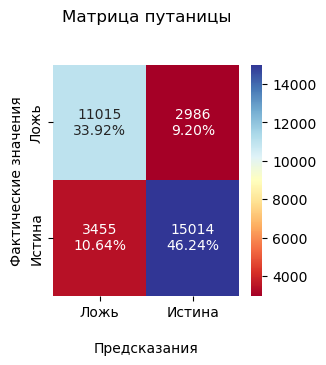

In [46]:
model_LR = LogisticRegression()
model_LR, accuracy_LR, roc_auc_LR, time_LR = model_create(model_LR, X_train, y_train, X_test, y_test)

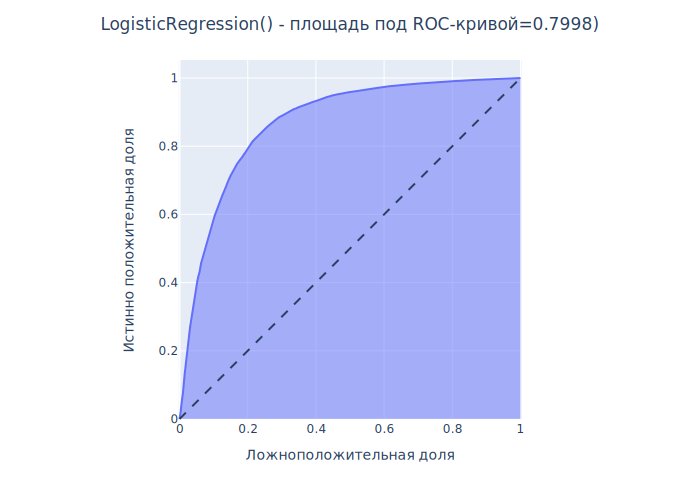

In [47]:
roc_auc(model_LR,  roc_auc_LR, X_test, y_test)

In [48]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['Logistic Regression', accuracy_LR, roc_auc_LR, time_LR]

### <u>Дерево решений:<u>

Точность прогноза = 0.9426547582383739
AUC ROC - Площадь под кривой ошибок = 0.9417466831699007
Затраченное время = 0.5454471111297607
              precision    recall  f1-score   support

           0    0.93209   0.93515   0.93361     14001
           1    0.95071   0.94835   0.94953     18469

    accuracy                        0.94265     32470
   macro avg    0.94140   0.94175   0.94157     32470
weighted avg    0.94268   0.94265   0.94267     32470



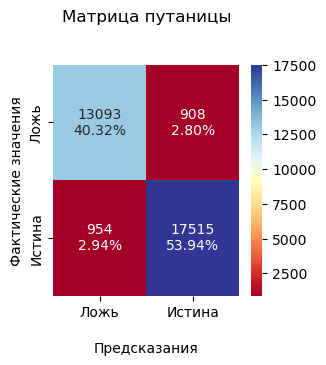

In [49]:
model_DC = DecisionTreeClassifier()
model_DC, accuracy_DC, roc_auc_DC, time_DC = model_create(model_DC, X_train, y_train, X_test, y_test)

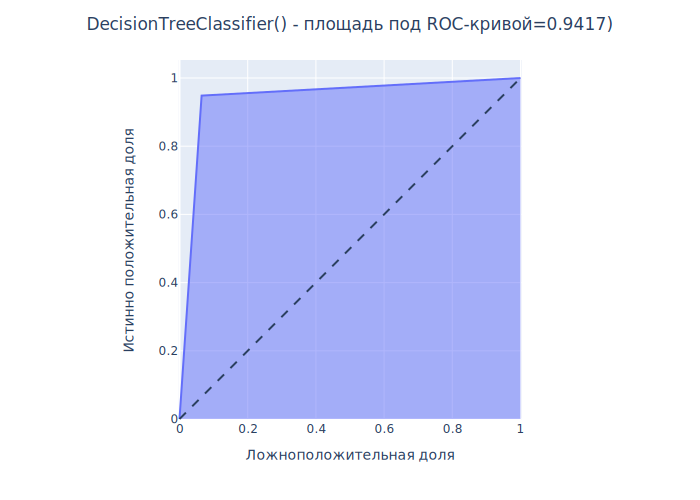

In [50]:
roc_auc(model_DC, roc_auc_DC, X_test, y_test)

In [68]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['DecisionTreeClassifier', accuracy_DC, roc_auc_DC, time_DC]

### <u>Случайный лес:<u>

Точность прогноза = 0.9617801047120419
AUC ROC - Площадь под кривой ошибок = 0.9590251628762746
Затраченное время = 11.499185800552368
              precision    recall  f1-score   support

           0    0.97141   0.93900   0.95493     14001
           1    0.95490   0.97905   0.96682     18469

    accuracy                        0.96178     32470
   macro avg    0.96315   0.95903   0.96088     32470
weighted avg    0.96202   0.96178   0.96169     32470



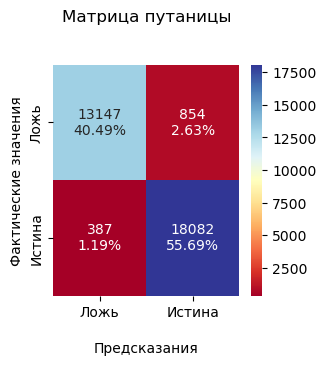

In [51]:
model_RF = RandomForestClassifier()
model_RF, accuracy_RF, roc_auc_RF, time_RF = model_create(model_RF, X_train, y_train, X_test, y_test)

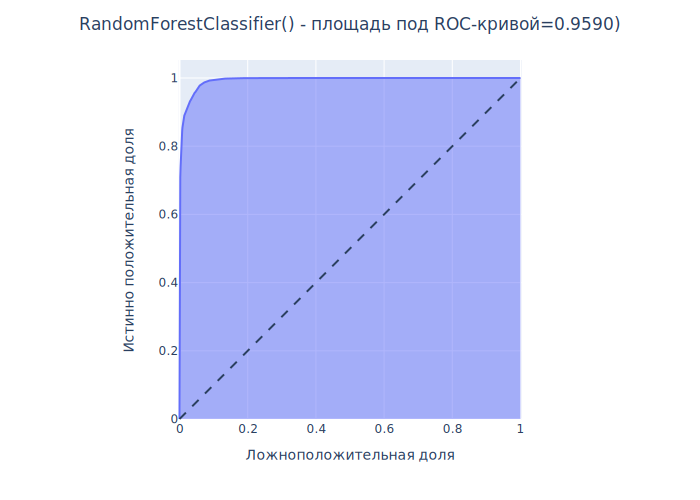

In [52]:
roc_auc(model_RF, roc_auc_RF, X_test, y_test)

In [53]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['Random Forest', accuracy_RF, roc_auc_RF, time_RF]

### <u>Наивный байесовский классификатор:<u>

Точность прогноза = 0.8665537419156144
AUC ROC - Площадь под кривой ошибок = 0.8606822805742443
Затраченное время = 0.08202099800109863
              precision    recall  f1-score   support

           0    0.86516   0.81801   0.84093     14001
           1    0.86751   0.90335   0.88507     18469

    accuracy                        0.86655     32470
   macro avg    0.86634   0.86068   0.86300     32470
weighted avg    0.86650   0.86655   0.86604     32470



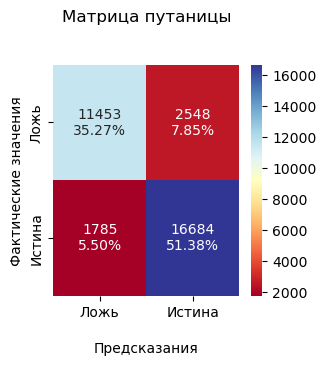

In [54]:
model_NB = GaussianNB() 
model_NB, accuracy_NB, roc_auc_NB, time_NB = model_create(model_NB, X_train, y_train, X_test, y_test)

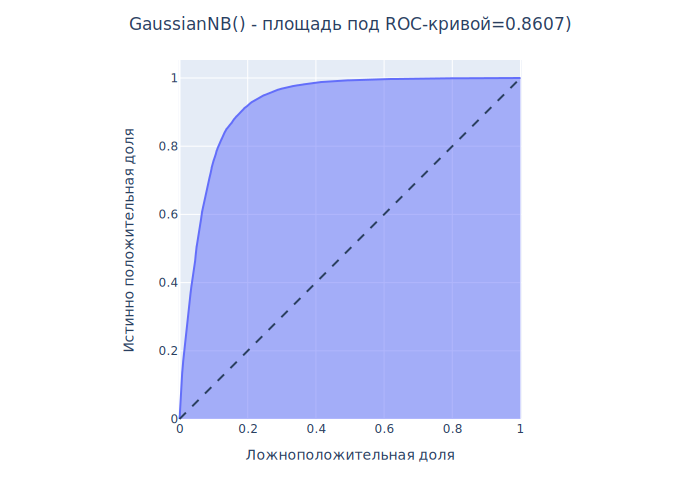

In [55]:
roc_auc(model_NB, roc_auc_NB, X_test, y_test)

In [56]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['Naive Bayes Classifier', accuracy_NB, roc_auc_NB, time_NB]

### <u>K-ближайшие соседи :<u>

Точность прогноза = 0.7751154912226671
AUC ROC - Площадь под кривой ошибок = 0.7647276140161381
Затраченное время = 10.05745792388916
              precision    recall  f1-score   support

           0    0.76581   0.68924   0.72551     14001
           1    0.78102   0.84022   0.80954     18469

    accuracy                        0.77512     32470
   macro avg    0.77341   0.76473   0.76752     32470
weighted avg    0.77446   0.77512   0.77330     32470



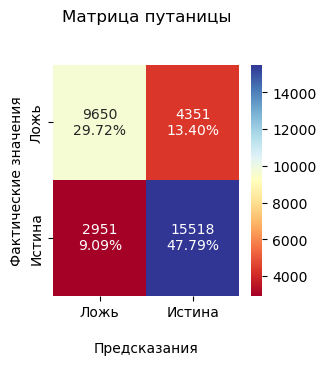

In [60]:
model_KNN = KNeighborsClassifier(n_neighbors=22)
model_KNN, accuracy_KNN, roc_auc_KNN, time_KNN = model_create(model_KNN, X_train, y_train, X_test, y_test)

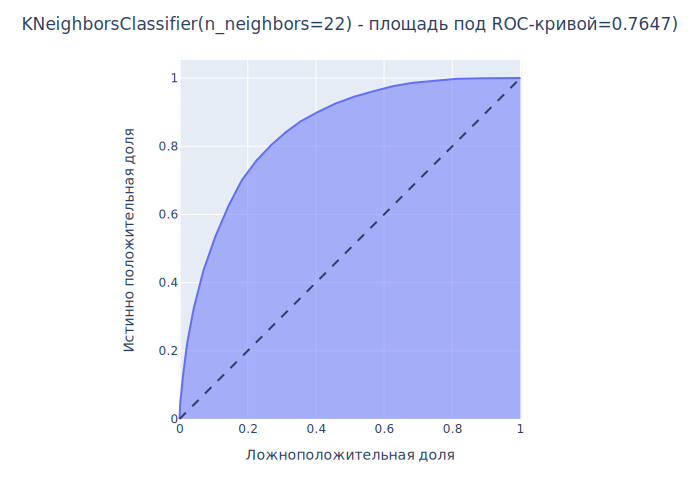

In [61]:
roc_auc(model_KNN, roc_auc_KNN, X_test, y_test)

In [62]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['K-Nearest Neighbors', accuracy_KNN, roc_auc_KNN, time_KNN]

### <u>Классификатор AdaBoost:<u>

Точность прогноза = 0.9276562981213428
AUC ROC - Площадь под кривой ошибок = 0.9251671665555444
Затраченное время = 4.148640155792236
              precision    recall  f1-score   support

           0    0.92377   0.90708   0.91535     14001
           1    0.93051   0.94326   0.93684     18469

    accuracy                        0.92766     32470
   macro avg    0.92714   0.92517   0.92609     32470
weighted avg    0.92760   0.92766   0.92757     32470



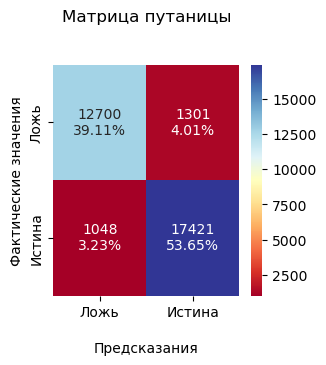

In [63]:
model_AB = AdaBoostClassifier(n_estimators=50,learning_rate=1)
model_AB, accuracy_AB, roc_auc_AB, time_AB = model_create(model_AB, X_train, y_train, X_test, y_test)

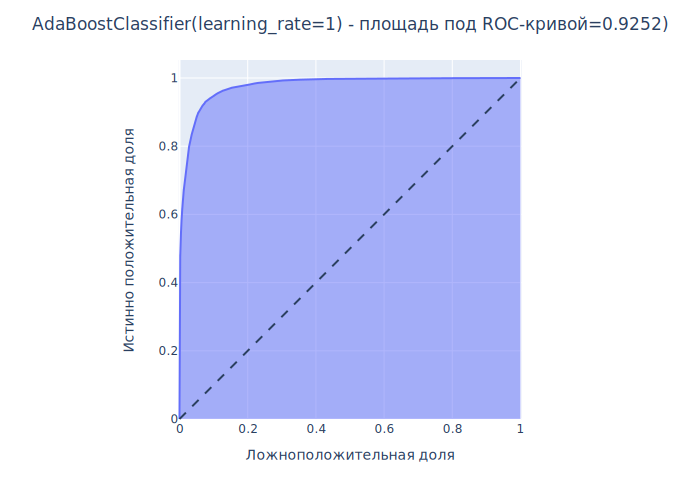

In [64]:
roc_auc(model_AB, roc_auc_AB, X_test, y_test)

In [65]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['AdaBoostClassifier', accuracy_AB, roc_auc_AB, time_AB]

#### Сравнениv моделb 
- Мы собрали данные по каждой модели, ниже мы их сортируем и отобразим. Также оценим модели с точки зрения ROC_AUC и общего времени, затраченного на выполнение.

In [69]:
df_class_accuracy.sort_values(by=['Время'], ascending=False)

,Метод,Точность,Кривая_ошибок,Время
1,Random Forest,0.961780,0.959025,11.499186
3,K-Nearest Neighbors,0.775115,0.764728,10.057458
0,Logistic Regression,0.801632,0.799830,4.700001
4,AdaBoostClassifier,0.927656,0.925167,4.148640
5,DecisionTreeClassifier,0.942655,0.941747,0.545447
2,Naive Bayes Classifier,0.866554,0.860682,0.082021


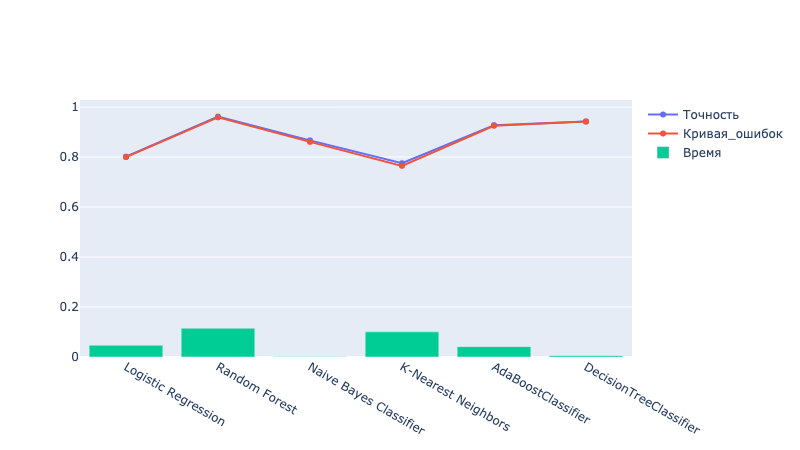

In [70]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_class_accuracy['Метод'],
        y=df_class_accuracy['Точность'],
        mode="lines+markers+text",
        name='Точность'
    ))
fig.add_trace(
    go.Scatter(
        x=df_class_accuracy['Метод'],
        y=df_class_accuracy['Кривая_ошибок'],
        mode="lines+markers+text",
        name='Кривая_ошибок'
    ))

fig.add_trace(
    go.Bar(
        x=df_class_accuracy['Метод'],
        y=df_class_accuracy['Время'] / 100,
        name='Время'
    ))              
gitly.show(fig)

### Заключение:
* Макимальные точность, ROC-AUC для **случайного леса**, минимальные для **K-ближайших соседей** 
* Затраченное время максимально для **случайного леса** , минимально для  **Наивного байесовского классификатора**
##### Для лучшего предсказания модели ищем 
* Максимальные ROC_AUC, точность
* Минимальное время 
#### **Дерево решений** является лучшим из алгоритмов, обученных прогнозировать точный результат, с **точностью** **95%** и **временем** выполнения **0.5**.